# Initial demo with data preprocessing from proof of concept

In [1]:
# Necessary Imports
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import os
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [2]:
'''
# Path to 1 data set
file_path = "C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files/user7/session_0041905381"

# Read the data from the file
with open(file_path, 'r') as f:
    lines = f.readlines()

# Skip the header and process the rest of the data
data_values = []

# Process each line
for line in lines[1:]:  # Skip the header line
    parts = line.strip().split(',')  # Split the line by commas
    x = float(parts[4])  # x-coordinate
    y = float(parts[5])  # y-coordinate
    client_timestamp = float(parts[1])  # client timestamp
    data_values.append([x, y, client_timestamp])

# Convert the list of data values into a NumPy array
data = np.array(data_values)

# Display the first 5 rows and the shape of the dataset
print(data[:5])  # Display the first 5 rows
print(data.shape)  # Display the shape of the dataset
'''


'\n# Path to 1 data set\nfile_path = "C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files/user7/session_0041905381"\n\n# Read the data from the file\nwith open(file_path, \'r\') as f:\n    lines = f.readlines()\n\n# Skip the header and process the rest of the data\ndata_values = []\n\n# Process each line\nfor line in lines[1:]:  # Skip the header line\n    parts = line.strip().split(\',\')  # Split the line by commas\n    x = float(parts[4])  # x-coordinate\n    y = float(parts[5])  # y-coordinate\n    client_timestamp = float(parts[1])  # client timestamp\n    data_values.append([x, y, client_timestamp])\n\n# Convert the list of data values into a NumPy array\ndata = np.array(data_values)\n\n# Display the first 5 rows and the shape of the dataset\nprint(data[:5])  # Display the first 5 rows\nprint(data.shape)  # Display the shape of the dataset\n'

In [3]:
# Define the root directory containing all user directories
root_directory = "C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files"

# Initialize a list to store all trajectories from all files
all_trajectories = []

# Iterate over all directories and files
for subdir, _, files in os.walk(root_directory):
    for filename in files:
        file_path = os.path.join(subdir, filename)
        
        # Read the data from the file
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Skip the header and process the rest of the data
        data_values = []
        state_values = []

        for line in lines[1:]:  # Skip the header line
            parts = line.strip().split(',')  # Split the line by commas
            x = float(parts[4])  # x-coordinate
            y = float(parts[5])  # y-coordinate
            client_timestamp = float(parts[1])  # client timestamp
            state = parts[3]  # State (e.g., "Move", "Pressed")
            
            data_values.append([x, y, client_timestamp])
            state_values.append(state)

        # Convert to NumPy arrays
        data = np.array(data_values)
        state_values = np.array(state_values)

        # Trajectory extraction for this file
        trajectories = []
        current_trajectory = []

        for i in range(len(data)):
            if state_values[i] == "Move":  # Only include points with state == "Move"
                current_trajectory.append(data[i])
            else:
                # If the state changes from "Move", save the current trajectory
                if current_trajectory:
                    trajectories.append(np.array(current_trajectory))
                    current_trajectory = []

        # Save the last trajectory if it exists
        if current_trajectory:
            trajectories.append(np.array(current_trajectory))

        # Add trajectories from this file to the global list
        all_trajectories.extend(trajectories)

        # Print summary for this file
        print(f"Processed {file_path}: Extracted {len(trajectories)} trajectories.")

# Display total results across all files
print(f"Total trajectories extracted from all files: {len(all_trajectories)}")

Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_2144641057: Extracted 1173 trajectories.
Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_5265929106: Extracted 1413 trajectories.
Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_5815391283: Extracted 2311 trajectories.
Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_7409188284: Extracted 1287 trajectories.
Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_8872593360: Extracted 1589 trajectories.
Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_9031593624: Extracted 1800 trajectories.
Processed C:/Users/vkuma/School/Rice/Dee

In [4]:
# Filter trajectories for length 25+ and trim to 25 points
filtered_trajectories = []

for traj in all_trajectories:
    if len(traj) >= 25:  # Check if the trajectory has at least 25 points
        x_values = traj[:, 0]
        y_values = traj[:, 1]
        t_values = traj[:, 2]
        # Ensure all points are in a reasonable range for normalization
        if np.all(x_values < 1000) and np.all(y_values < 1000):
            filtered_trajectories.append(traj[:25])  # Trim to exactly 25 points

# Print the results
print(f"Number of filtered trajectories (length 25+ and all x, y < 1000): {len(filtered_trajectories)}")

Number of filtered trajectories (length 25+ and all x, y < 1000): 15498


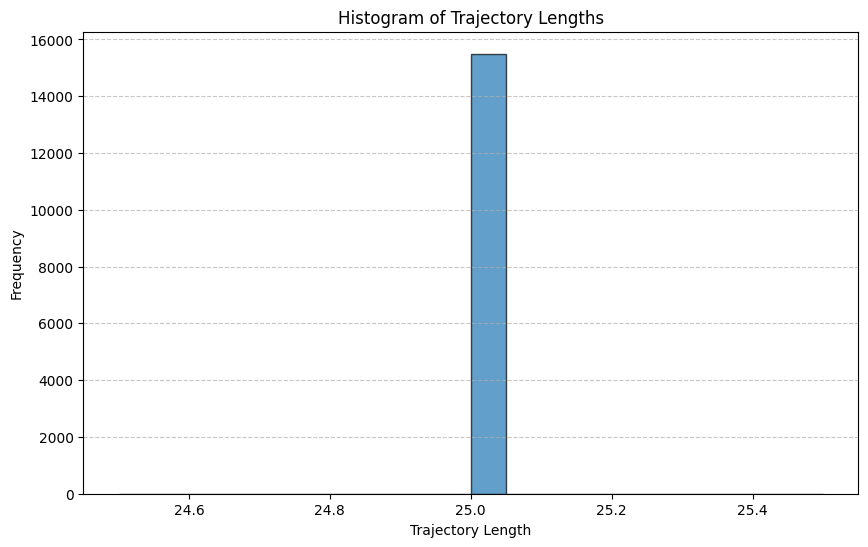

In [5]:
# Calculate the lengths of all trajectories
trajectory_lengths = [len(traj) for traj in filtered_trajectories]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(trajectory_lengths, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of Trajectory Lengths")
plt.xlabel("Trajectory Length")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
# Rescale each trajectory to start at (0, 0, 0)
rescaled_trajectories = []

for traj in filtered_trajectories:
    start_point = traj[0]  # Starting point (x, y, t)
    rescaled_traj = traj - start_point  # Subtract the starting point from all points
    if np.all(rescaled_traj[:,2] < 1):
        rescaled_trajectories.append(rescaled_traj)

# Convert to a NumPy array for training
rescaled_trajectories = np.array(rescaled_trajectories)

# Calculate the maximum values for x and y
max_x = np.max([np.max(np.abs(rescaled_trajectories[i][:, 0])) for i in range(len(rescaled_trajectories))])
max_y = np.max([np.max(np.abs(rescaled_trajectories[i][:, 1])) for i in range(len(rescaled_trajectories))])

# Scale each trajectory's x and y values between [-1, 1]
for i in range(len(rescaled_trajectories)):
    # Scale the x (first column) and y (second column) of each trajectory
    rescaled_trajectories[i][:, 0] /= max_x  # Scale x by max_x
    rescaled_trajectories[i][:, 1] /= max_y  # Scale y by max_y

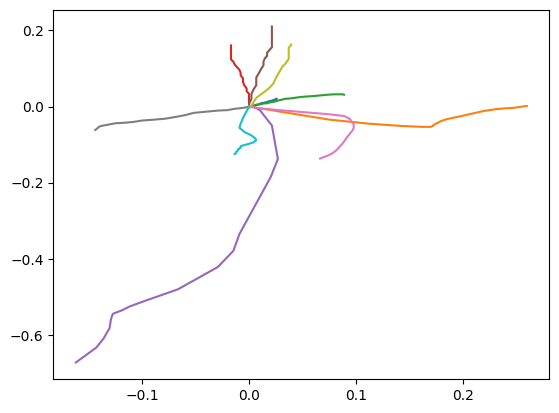

In [7]:
random_selection = np.random.randint(0,len(rescaled_trajectories), 10)
for i in random_selection:
    plt.plot(rescaled_trajectories[i][:,0], rescaled_trajectories[i][:,1])

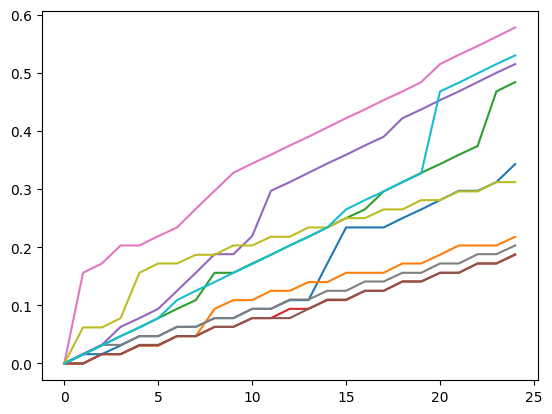

In [8]:
for i in random_selection:
    #plt.plot(filtered_trajectories[i][:,2])
    plt.plot(rescaled_trajectories[i][:,2])

In [9]:
x_values = [trajectory[:, 0] for trajectory in rescaled_trajectories]

Text(0, 0.5, 'Frequency')

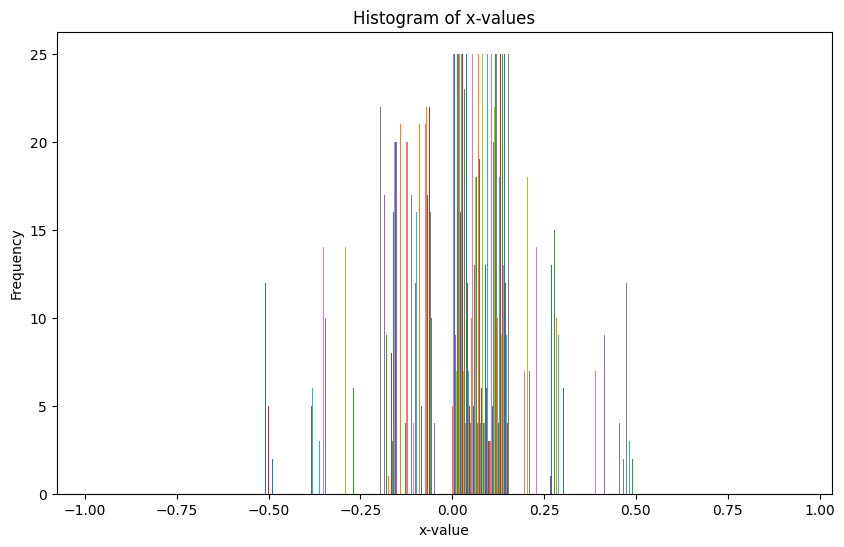

In [10]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(x_values)
plt.title("Histogram of x-values")
plt.xlabel("x-value")
plt.ylabel("Frequency")

In [11]:
inputs = []
outputs = []

for traj in rescaled_trajectories:
    endpoint = traj[-1, :2]  # Final point [x_end, y_end] (omit time t)
    trajectory = traj[:, :]  # Full trajectory [x, y] (omit time t)
    inputs.append(endpoint)
    outputs.append(trajectory)

# Convert inputs and outputs to NumPy arrays
inputs = np.array(inputs)
outputs = np.array(outputs)
print(f"Inputs shape: {np.shape(inputs)}")
print(f"Outputs shape: {np.shape(outputs)}")

Inputs shape: (7719, 2)
Outputs shape: (7719, 25, 3)


In [12]:
trajectory

array([[0.        , 0.        , 0.        ],
       [0.00449438, 0.00118765, 0.016     ],
       [0.00898876, 0.0023753 , 0.031     ],
       [0.01797753, 0.0023753 , 0.031     ],
       [0.0258427 , 0.0023753 , 0.047     ],
       [0.03370787, 0.00475059, 0.047     ],
       [0.04269663, 0.00593824, 0.062     ],
       [0.0505618 , 0.00831354, 0.078     ],
       [0.05842697, 0.00950119, 0.078     ],
       [0.06741573, 0.01187648, 0.078     ],
       [0.0752809 , 0.01662708, 0.094     ],
       [0.08651685, 0.02256532, 0.094     ],
       [0.09775281, 0.02494062, 0.109     ],
       [0.10898876, 0.02731591, 0.109     ],
       [0.12022472, 0.02969121, 0.125     ],
       [0.13146067, 0.03206651, 0.125     ],
       [0.14269663, 0.03444181, 0.14      ],
       [0.15730337, 0.03800475, 0.14      ],
       [0.17078652, 0.0415677 , 0.156     ],
       [0.18314607, 0.04275534, 0.156     ],
       [0.19438202, 0.04631829, 0.172     ],
       [0.20674157, 0.04869359, 0.172     ],
       [0.

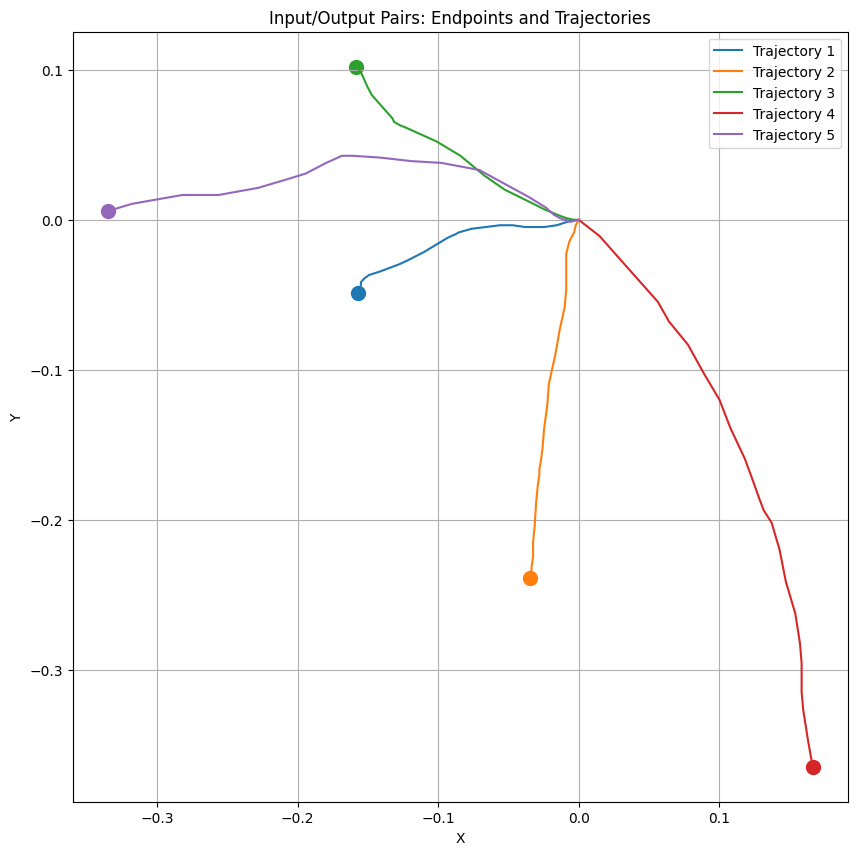

In [13]:
num_samples = 5
indices = np.random.choice(len(inputs), num_samples, replace=False)

# Create a plot
plt.figure(figsize=(10, 10))

for idx, i in enumerate(indices):
    endpoint = inputs[i]  # Endpoint of the trajectory
    trajectory = outputs[i]  # Full trajectory

    # Plot the trajectory
    plt.plot(trajectory[:, 0], trajectory[:, 1], label=f'Trajectory {idx+1}')
    # Plot the endpoint
    plt.scatter(endpoint[0], endpoint[1], marker='o', s=100)  # Match color with trajectory

plt.title("Input/Output Pairs: Endpoints and Trajectories")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()

In [14]:
class TrajectoryDataset(Dataset):
    def __init__(self, inputs, outputs):
        """
        Custom Dataset for trajectory data.
        :param inputs: NumPy array of shape (n_trajectories, 2) - Endpoints [x_end, y_end]
        :param outputs: NumPy array of shape (n_trajectories, n_points, 2) - Trajectories [x, y]
        """
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.outputs = torch.tensor(outputs, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        """
        Return a single input-output pair at the specified index.
        """
        input_data = self.inputs[idx]
        output_data = self.outputs[idx]
        return input_data, output_data


# Create Dataset
trajectory_dataset = TrajectoryDataset(inputs, outputs)

# Dataset sizes
n_total = len(trajectory_dataset)
train_size = int(0.7 * n_total)
val_size = int(0.15 * n_total)
test_size = n_total - train_size - val_size  # Ensure total adds up correctly

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    trajectory_dataset, [train_size, val_size, test_size]
)

# Create DataLoaders for each split
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Iterating through the training DataLoader
for batch_idx, (endpoints, trajectories) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}")
    print("Endpoints:", endpoints.shape)  # Shape: (batch_size, 2)
    print("Trajectories:", trajectories.shape)  # Shape: (batch_size, n_points, 2)
    break  # Process one batch as an example

Batch 1
Endpoints: torch.Size([32, 2])
Trajectories: torch.Size([32, 25, 3])


In [15]:
class TrajectoryMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, trajectory_len):
        super(TrajectoryMLP, self).__init__()
        self.trajectory_len = trajectory_len  # Number of coordinate pairs in the trajectory

        # Define the MLP
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, trajectory_len * output_dim)  # Output full trajectory
        )

    def forward(self, x):
        # Pass the input through the MLP
        out = self.mlp(x)  # Shape: (batch_size, trajectory_len * output_dim)

        # Reshape to get trajectory points
        out = out.view(-1, self.trajectory_len, output_dim)  # Shape: (batch_size, trajectory_len, output_dim)

        return out

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, trajectory_len):
        super(TrajectoryLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.trajectory_len = trajectory_len

        # Define LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # Fully connected layer to project LSTM outputs to the desired trajectory points
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_dim)
        # x should be of shape (batch_size, trajectory_len, input_dim)

        # Pass the input through the LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, trajectory_len, hidden_dim)

        # Apply the fully connected layer to each timestep
        out = self.fc(lstm_out)  # Shape: (batch_size, trajectory_len, output_dim)

        return out
    
# Hyperparameters
input_dim = 2  # Endpoint [x_end, y_end]
hidden_dim = 128  # Number of hidden units
output_dim = 3  # Trajectory points (x, y)
trajectory_len = 25  # Number of coordinate pairs
batch_size = 32
learning_rate = 1e-4
epochs = 1000

# Initialize the model
model = TrajectoryMLP(input_dim, hidden_dim, output_dim, trajectory_len)

In [16]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Scheduler to decay the learning rate 4 times over the training time
scheduler = StepLR(optimizer, step_size=int(epochs/4), gamma=0.1)  # Reduce LR by a factor of 0.1 5 times over training

# Training loop with penalty term
penalty_weight = 1e4  # Weight for the penalty term

# Lists to store losses
total_losses = []
trajectory_losses = []
penalty_losses = []
validation_losses = []

# Variable to track the lowest validation loss and save the best model
best_val_loss = float('inf')  # Initialize to a large value
best_model_path = "best_model.pth"  # Path to save the best model

for epoch in range(epochs):
    # Initialize accumulators for training losses
    epoch_total_loss = 0.0
    epoch_trajectory_loss = 0.0
    epoch_penalty_loss = 0.0

    # Training phase
    model.train()  # Set model to training mode
    for batch_idx, (endpoints, trajectories) in enumerate(train_loader):
        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(endpoints)  # Shape: (batch_size, trajectory_len, output_dim)

        # Compute the primary trajectory loss (MSE)
        loss_trajectory = criterion(outputs, trajectories)

        # Compute the penalty term
        predicted_endpoints = outputs[:, -1, :]  # The last point in the predicted trajectory
        loss_penalty = torch.mean((predicted_endpoints - trajectories[:, -1]) ** 2)

        # Total loss
        total_loss = loss_trajectory + penalty_weight * loss_penalty

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        # Accumulate losses for this batch
        epoch_total_loss += total_loss.item()
        epoch_trajectory_loss += loss_trajectory.item()
        epoch_penalty_loss += penalty_weight * loss_penalty.item()

    # Average training losses for the epoch
    epoch_total_loss /= len(train_loader)
    epoch_trajectory_loss /= len(train_loader)
    epoch_penalty_loss /= len(train_loader)

    # Store epoch training losses
    total_losses.append(epoch_total_loss)
    trajectory_losses.append(epoch_trajectory_loss)
    penalty_losses.append(epoch_penalty_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    validation_loss = 0.0
    with torch.no_grad():  # No gradient computation for validation
        for endpoints, trajectories in val_loader:
            outputs = model(endpoints)  # Forward pass
            loss_trajectory = criterion(outputs, trajectories)
            predicted_endpoints = outputs[:, -1, :]  # The last point in the predicted trajectory
            loss_penalty = torch.mean((predicted_endpoints - trajectories[:, -1]) ** 2)

            # Total validation loss
            total_loss = loss_trajectory + penalty_weight * loss_penalty
            validation_loss += total_loss.item()

    # Average validation loss for the epoch
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss)

    # Save the model if validation loss is the lowest so far
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}: New best validation loss: {validation_loss}. Model saved to {best_model_path}.")

    # Step the scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs}, Total Loss: {epoch_total_loss}, "
          f"Trajectory Loss: {epoch_trajectory_loss}, Penalty Loss: {epoch_penalty_loss}, "
          f"Validation Loss: {validation_loss}, Learning Rate: {scheduler.get_last_lr()[0]}")

Epoch 1: New best validation loss: 181.9790098860457. Model saved to best_model.pth.
Epoch 1/1000, Total Loss: 342.9097648485172, Trajectory Loss: 0.029082071328171963, Penalty Loss: 342.88068296464945, Validation Loss: 181.9790098860457, Learning Rate: 0.0001
Epoch 2: New best validation loss: 122.99798501504434. Model saved to best_model.pth.
Epoch 2/1000, Total Loss: 132.38929800451155, Trajectory Loss: 0.012208392187820737, Penalty Loss: 132.3770901970786, Validation Loss: 122.99798501504434, Learning Rate: 0.0001
Epoch 3: New best validation loss: 121.71588176005595. Model saved to best_model.pth.
Epoch 3/1000, Total Loss: 111.75650821211775, Trajectory Loss: 0.008316124643381002, Penalty Loss: 111.74819255853899, Validation Loss: 121.71588176005595, Learning Rate: 0.0001
Epoch 4: New best validation loss: 120.76769297831767. Model saved to best_model.pth.
Epoch 4/1000, Total Loss: 110.42220288338746, Trajectory Loss: 0.0069500186767142555, Penalty Loss: 110.41525247115531, Valida

In [17]:
'''
class TrajectoryModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(TrajectoryModel, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Assume x has shape (batch_size, seq_len, input_dim)
        out, _ = self.rnn(x)
        out = self.fc(out)  # Shape: (batch_size, seq_len, output_dim)
        return out

# Define model, loss, and optimizer
input_dim = 2  # Endpoint [x_end, y_end]
hidden_dim = 64
output_dim = 2  # Trajectory points [x, y]
num_layers = 2

model = TrajectoryModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
'''

'\nclass TrajectoryModel(torch.nn.Module):\n    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):\n        super(TrajectoryModel, self).__init__()\n        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)\n        self.fc = torch.nn.Linear(hidden_dim, output_dim)\n\n    def forward(self, x):\n        # Assume x has shape (batch_size, seq_len, input_dim)\n        out, _ = self.rnn(x)\n        out = self.fc(out)  # Shape: (batch_size, seq_len, output_dim)\n        return out\n\n# Define model, loss, and optimizer\ninput_dim = 2  # Endpoint [x_end, y_end]\nhidden_dim = 64\noutput_dim = 2  # Trajectory points [x, y]\nnum_layers = 2\n\nmodel = TrajectoryModel(input_dim, hidden_dim, output_dim, num_layers)\ncriterion = torch.nn.MSELoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.000001)\n'

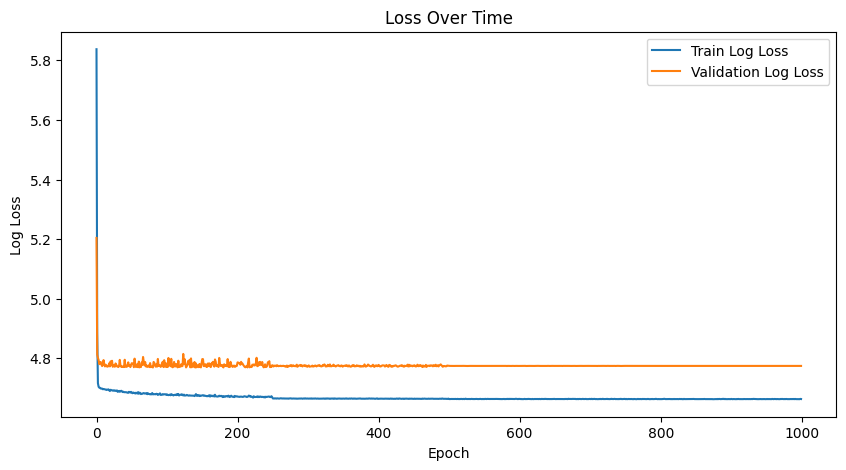

In [18]:
# Plot epoch losses
plt.figure(figsize=(10, 5))
plt.plot(np.log(total_losses), label="Train Log Loss")
plt.plot(np.log(validation_losses), label = "Validation Log Loss")
plt.title("Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

In [19]:
# Load the best model state
model.load_state_dict(torch.load(best_model_path))
print("Best validation model loaded for evaluation.")

Best validation model loaded for evaluation.


In [20]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize accumulators for test losses
test_trajectory_loss = 0.0
test_penalty_loss = 0.0
test_total_loss = 0.0

# Evaluate on the test set
with torch.no_grad():  # No gradient computation during evaluation
    for endpoints, trajectories in test_loader:
        # Forward pass
        outputs = model(endpoints)  # Output: (batch_size, trajectory_len, output_dim)

        # Compute the primary trajectory loss (MSE)
        loss_trajectory = criterion(outputs, trajectories)

        # Compute the penalty term
        predicted_endpoints = outputs[:, -1, :]  # The last point in the predicted trajectory
        loss_penalty = torch.mean(torch.sum((predicted_endpoints - trajectories[:, -1]) ** 2, dim=1))  # MSE for endpoint

        # Total loss
        total_loss = loss_trajectory + penalty_weight * loss_penalty

        # Accumulate test losses
        test_trajectory_loss += loss_trajectory.item()
        test_penalty_loss += loss_penalty.item() * penalty_weight
        test_total_loss += total_loss.item()

# Average test losses
test_trajectory_loss /= len(test_loader)
test_penalty_loss /= len(test_loader)
test_total_loss /= len(test_loader)

# Output the test losses
print(f"Test Losses: Total Loss = {test_total_loss:.6f}, "
      f"Trajectory Loss = {test_trajectory_loss:.6f}, "
      f"Penalty Loss = {test_penalty_loss:.6f}")

Test Losses: Total Loss = 332.075733, Trajectory Loss = 0.005652, Penalty Loss = 332.070084


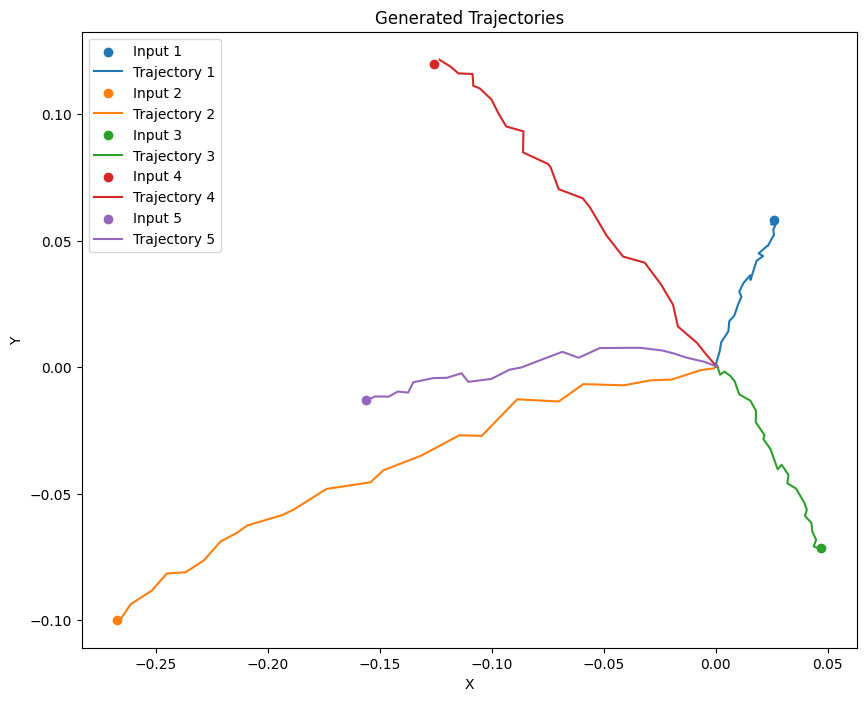

In [21]:
# Ensure the model is in evaluation mode
model.eval()

# Sample 10 random trajectories from the test set
num_samples = 5
random_indices = np.random.choice(len(test_dataset), size=num_samples, replace=False)

# Generate and store trajectories for plotting
generated_trajectories = []

with torch.no_grad():
    for idx in random_indices:
        # Get the input (endpoints) from the test set
        endpoint, _ = test_dataset[idx]

        # Add batch dimension for model input
        endpoint_input = endpoint.unsqueeze(0)  # Shape: (1, input_dim)

        # Generate the trajectory
        generated_trajectory = model(endpoint_input).squeeze(0).numpy()  # Remove batch dimension

        # Store the generated trajectory
        generated_trajectories.append(generated_trajectory)

# Plot the generated trajectories
plt.figure(figsize=(10, 8))
for i, trajectory in enumerate(generated_trajectories):
    # Retrieve the corresponding input endpoint
    endpoint = test_dataset[random_indices[i]][0].numpy()  # Assuming the endpoint is in the first position
    
    # Plot the endpoint with the same color as the trajectory
    plt.scatter(endpoint[0], endpoint[1], label=f"Input {i+1}")
    plt.plot(trajectory[:, 0], trajectory[:, 1], label=f"Trajectory {i+1}")
    

plt.title("Generated Trajectories")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

Text(0.5, 0, 'Steps Taken')

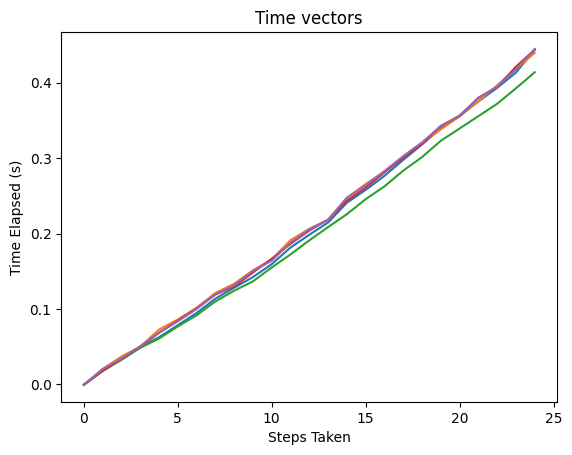

In [23]:
for i, trajectory in enumerate(generated_trajectories):
    plt.plot(trajectory[:, 2])
plt.title("Time vectors")
plt.ylabel("Time Elapsed (s)")
plt.xlabel("Steps Taken")